# Monkey Functions
- 1.) Make pipeline for predictions
- 2.) Cycle through all the features and make predictions 
- 3.) Make software that allows for the user to enter the following and get preditctions out of it (i.e. train on all data and get novel predictions - dramatic presentation)
    - Age
    - Sex
    - Dose
    - Time since Irradiation
- 4.) Incorporate optimization in the pipeline
- 5.) Pipeline for health outcomes
    - able to cycle through as well

In [3]:
### Using monkey_env/ ###
### If giving a tqb error, run this code twice###

# handling data
import pandas as pd
import numpy as np
import datetime

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Statistics
from scipy import stats
#import statsmodels.api as sm
#import statsmodels.imputation.mice as smi
#import scipy.cluster.hierarchy as hac
#from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.gridspec as gridspec
import math
import random


#SHAP Value stuff
import shap
from shap import TreeExplainer
from shap import GradientExplainer
from shap import DeepExplainer
from shap import KernelExplainer
from shap import SamplingExplainer
from shap import PartitionExplainer

#ML stuff
import catboost
from catboost import CatBoostClassifier, Pool, CatBoostRegressor, CatBoost
from catboost import Pool

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

#language handling
#import bert

#from mxnet import nd, autograd, gluon
#from mxnet.gluon import nn, rnn
#import mxnet as mx

#fix the error that pops up about ipwydgets 
from tqdm import tqdm
#from .autonotebook import tqdm as notebook_tqdm

print("Setup Complete")


Setup Complete


In [4]:
pwd

'/Users/aidanlew/Desktop/cmb/codes/monkey_irrad_sept-2022'

In [5]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


In [6]:
def parser(x):
    return datetime.datetime.strptime(x,'%d-%m-%y')


# Predicting Biomarker Levels and Health Outcomes

## Data loading

In [7]:
# Make a df of the binary health data of the monkeys
minhealth_monkey_df = pd.read_excel('../Documents/demographic_data_r2.xlsx',
                    sheet_name=2,
                    skiprows = 0,
                    #usecols = ,
                    engine = 'openpyxl',
                    date_parser=parser
                         )

minhealth_monkey_df['Animal_Status'] = minhealth_monkey_df['Animal_Status'].map({'LIVING':1, 'DECEASED': 0})
#minhealth_monkey_df.head(15)
minhealth_monkey_df.columns


Index(['ID', 'Time_Under_Observation_(yrs)', 'Dose_(Gy)', 'Irrad_Age_(months)',
       'Years_Since_Irrad', 'Current_Age_(years)', 'Animal_Status',
       'Diabetes_(Y/N)', 'Cataracts_(Y/N)', 'Arthritis_(Y/N)',
       'Periodontitis_(Y/N)', 'GI_(Y/N)', 'Behavior_(Y/N)', 'Tumor_(Y/N)',
       'Heart_(Y/N)', 'Hypertension_(Y/N)', 'Testicular Atrophy_(Y/N)',
       'Ovarian Dysfunction_(Y/N)', 'Hepatic_(Y/N)', 'Kidney_(Y/N)',
       'Lung_(Y/N)', 'Bone_(Y/N)', 'Overweight_(Y/N)', 'Underweight_(Y/N)',
       'Brain Lesion_(Y/N)'],
      dtype='object')

In [8]:
# See our monkey sample size
print('Total Monkeys:{}'.format(minhealth_monkey_df['ID'].nunique()))
 
# Count the control monkeys
print('Non-Irradiated Monkeys:{}'.format(minhealth_monkey_df['Dose_(Gy)'].value_counts()[0]))
 
# Count the irradiated monkeys
#print('Irradiated Samples:{}'.format(minhealth_monkey_df['Dose_(Gy)'].value_counts()[!=0]))



Total Monkeys:152
Non-Irradiated Monkeys:32


In [9]:
#Makee a df for the blood analytic data
minbio_monkey_df = pd.read_excel('../Documents/full_monkey_data_r2.xlsx',
                    #sheet_name=1,
                    skiprows = 0,
                    usecols = ['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
                    engine = 'openpyxl',
                    date_parser=parser
                         )

#Set the index to the monkey ID and make the labels not read as integers
minbio_monkey_df.set_index(['ID'])
minbio_monkey_df['ID'] = minbio_monkey_df['ID'].astype(str)

#minbio_monkey_df.dropna(axis=0, inplace=True) 

minbio_monkey_df.columns
#minbio_monkey_df.tail()


Cannot parse header or footer so it will be ignored


Index(['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
      dtype='object')

In [10]:
#Makee a df were there is one monkey's data missing (the same in the single_monkey_df)
oneless_df = pd.read_excel('../Documents/full_monkey_data_r2.xlsx',
                    sheet_name=1,
                    skiprows = 0,
                    usecols = ['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
                    engine = 'openpyxl',
                    date_parser=parser
                         )

#Set the index to the monkey ID and make the labels not read as integers
oneless_df.set_index(['ID'])

oneless_df['ID'] = oneless_df['ID'].astype(str)

#oneless_dff.dropna(axis=0, inplace=True) 

#oneless_df.columns
oneless_df.tail()

Cannot parse header or footer so it will be ignored


,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
4529,2112,Rhesus-Chinese,2020-09-23 00:00:00,No,NaT,1999-09-28,M,Research,NaN,NaN,...,67.0,6.2,1.1,0.0,1696,4422,409,73,0,289
4530,2112,Rhesus-Chinese,2021-03-04 00:00:00,No,NaT,1999-09-28,M,Research,NaN,NaN,...,56.1,9.1,1.5,0.0,1312,2210,359,59,0,284
4531,2210,Rhesus-Indian,2021-09-07 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,26.8,12.3,1.2,0.0,3104,1394,640,62,0,311
4532,2210,Rhesus-Indian,2021-09-20 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,36.2,10.9,1.7,0.0,2970,2100,632,99,0,348
4533,2210,Rhesus-Indian,2021-10-07 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,16.0,21.0,3.0,0.0,3360,896,1176,168,0,329


In [11]:
# Make a df of a single monkey's blood analytic data
single_minbio_df = minbio_monkey_df.copy()
single_minbio_df = single_minbio_df[single_minbio_df['ID'] == '2046']
single_minbio_df.set_index(['ID'])
#single_minbio_df.reset_index()
single_minbio_df.head()


,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
33,2046,Rhesus-Chinese,2017-11-02,Yes,2014-04-09,2007-07-03,F,Clinical,1303.0,43.0,...,44.6,5.5,0.5,0.0,1877,1695,209,19,0,276
34,2046,Rhesus-Chinese,2017-12-13,Yes,2014-04-09,2007-07-03,F,Clinical,1344.0,44.0,...,40.5,7.4,0.0,0.0,3647,2835,518,0,0,386
35,2046,Rhesus-Chinese,2018-01-02,Yes,2014-04-09,2007-07-03,F,Research,1364.0,45.0,...,39.9,6.0,0.3,0.3,2140,1596,240,12,12,309
36,2046,Rhesus-Chinese,2018-01-31,Yes,2014-04-09,2007-07-03,F,Research,1393.0,46.0,...,46.8,5.6,0.5,0.0,2025,2012,241,22,0,275
37,2046,Rhesus-Chinese,2018-04-05,Yes,2014-04-09,2007-07-03,F,Research,1457.0,48.0,...,22.8,5.8,0.1,0.1,6123,1961,499,9,9,325


# PLOTTING FUNCTION 

In [14]:
def predict_and_plot(model, X_validation, y_validation, y):
    
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)


    # Plot the predictions
    fig, ax = plt.subplots()
    ax.scatter(y_validation, a_df)

    ax.plot([y.min(), y.max()], [y.min(), y.max()], 
            'k-', 
            linewidth=1, 
            markersize=120
    )

    #Plot axis titles
    xlab = input("X axis name:")
    ylab = input("Y axis name:")
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

    #Title of the plot
    plot_title = input("Plot Title:")
    show_iters = model.get_param('iterations')  
    ax.set_title(plot_title + "\nIterations: {}".format(str(show_iters))
                 ,
                 fontsize=15
    )
    
    #cordinates for the R2 value box
    xmin, xmax, ymin, ymax = plt.axis()
    yrange = ymax-ymin
    xrange = xmax-xmin

            
    #Plotting the R2 score
    ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.1*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )
    plt.show()

# MODEL FUCTION

In [15]:
def regression_model_formation (X,y,cat_features):
    model = input('Model Name')
    iterations = float(input('Iterations'))
    learning_rate = float(input('Learning Rate'))
    early_stopping_rounds = float(input('Stopping Rounds'))
    
    model = CatBoostRegressor(iterations=iterations, 
                              learning_rate=learning_rate,
                               early_stopping_rounds= early_stopping_rounds
                             )
    model.fit(X,y,cat_features=cat_features  
         )

# MODEL, PREDICT, AND PLOT FXN

In [17]:
def model_pred_plot (X, y, cat_features, X_validation, y_validation):
    ### Model Formation ###
    model = input('Model Name')
    iterations = float(input('Iterations'))
    learning_rate = float(input('Learning Rate'))
    early_stopping_rounds = float(input('Stopping Rounds'))
    
    model = CatBoostRegressor(iterations=iterations, 
                              learning_rate=learning_rate,
                               early_stopping_rounds= early_stopping_rounds
                             )
    model.fit(X,y,cat_features=cat_features  
         )

    ### Predictions ###
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)


    # Plot the predictions
    fig, ax = plt.subplots()
    ax.scatter(y_validation, a_df)

    ax.plot([y.min(), y.max()], [y.min(), y.max()], 
            'k-', 
            linewidth=1, 
            markersize=120
    )
    
    ### Plotting ###
    
    #Plot axis titles
    xlab = input("X axis name:")
    ylab = input("Y axis name:")
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

    #Title of the plot
    plot_title = input("Plot Title:")
    show_iters = model.get_param('iterations')  
    ax.set_title(plot_title + "\nIterations: {}".format(str(show_iters))
                 ,
                 fontsize=15
    )
    
    #cordinates for the R2 value box
    xmin, xmax, ymin, ymax = plt.axis()
    yrange = ymax-ymin
    xrange = xmax-xmin

            
    #Plotting the R2 score
    ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.1*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )
    plt.show()
    

# DATA SETUP FUNCTION

In [18]:
def data_setup (df, cat_features):
    ylabel = input('Target Feature Column')  
    y = df[ylabel]
    X = df.drop(['ID',ylabel],axis=1)
    test_size = float(input('Test Size'))
    
    (train_df, test_df)= df, df
   
    cat_features= list(range(0,X[X.columns[:1]].shape[1]))
   

    #put the data into the pool
    pool = Pool(data=X, label=y, cat_features=cat_features)

    #train tesr split - 30% test
    data= train_test_split(X, y, test_size=0.3, random_state=0)

    #### The order of this matters###
    X_train, X_validation, y_train, y_validation= data

    train_pool = Pool(
        data = X_train,
        label = y_train,
        cat_features = cat_features
    )

    validation_pool = Pool(
        data = X_validation,
        label = y_validation,
        cat_features = cat_features
    )

# PIPELINE FOR REGRESSION


In [22]:
def regression_pipeline (df):
    ##################### for this to work, the catagorical features need to be all to the left side of the df ####################
    
    ### Data Setup ###
    
    (train_df, test_df)= df, df 
    
    #data labeling
    ylabel = input('Target Feature Column:')  
    y = df[ylabel]
    X = df.drop(['ID',ylabel],axis=1)
    
    #declare catagorical features
    cat_cols = int(input('How many catagorical columns:'))
    cat_features= list(range(0,X[X.columns[:cat_cols]].shape[1]))
    
    #put data into pool
    pool = Pool(data=X, label=y, cat_features=cat_features)
    
    #train tesr split - 30% test
    test_size = float(input('Test Size'))
    data= train_test_split(X, y, test_size=test_size, random_state=0)

    #The order of this matters#
    X_train, X_validation, y_train, y_validation= data

    train_pool = Pool(
        data = X_train,
        label = y_train,
        cat_features = cat_features
    )
    

    validation_pool = Pool(
        data = X_validation,
        label = y_validation,
        cat_features = cat_features
    )
    
    ### Model Formation ###
    iterations = float(input('Iterations:'))
    learning_rate = float(input('Learning Rate:'))
    early_stopping_rounds = float(input('Stopping Rounds:'))
    
    model = CatBoostRegressor(iterations=iterations, 
                              learning_rate=learning_rate,
                               early_stopping_rounds= early_stopping_rounds
                             )
    model.fit(X,y,cat_features=cat_features  
         )

    ### Predictions ###
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)

   
    ### Plotting ###
    # Plot the predictions
    fig, ax = plt.subplots()
    ax.scatter(y_validation, a_df)

    ax.plot([y.min(), y.max()], [y.min(), y.max()], 
            'k-', 
            linewidth=1, 
            markersize=120
    )
    
    #Plot axis titles
    ax.set_xlabel('Actual {}'.format(str(ylabel)))
    ax.set_ylabel('Predicted {}'.format(str(ylabel)))

    #Title of the plot
    plot_title = input("Plot Title:")
    show_iters = model.get_param('iterations')  
    ax.set_title(plot_title + "\nIterations: {}".format(str(show_iters))
                 ,fontsize=15
    )
   
    #cordinates for the R2 value box
    xmin, xmax, ymin, ymax = plt.axis()
    yrange = ymax-ymin
    xrange = xmax-xmin

            
    #Plotting the R2 score
    ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.1*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )
    
    plt.show() 
    
    ### Feature Importance ###

    feat = model.get_feature_importance(data=pool,
                       prettified=True,

    )
    
    print(feat)
    

# Single Monkey Preditions, whole data

In [20]:
#make a parent df
single_minbio_df.copy()
sreg_df = single_minbio_df

#Exclude datetime feautres
sreg_df=sreg_df.drop(['IRRAD_DATE','DOB','SAMPLE_DATE'],axis=1)
sreg_df.head(2)


,ID,Species,IRRAD,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
33,2046,Rhesus-Chinese,Yes,F,Clinical,1303.0,43.0,81.0,1.14,10.3,...,44.6,5.5,0.5,0.0,1877,1695,209,19,0,276
34,2046,Rhesus-Chinese,Yes,F,Clinical,1344.0,44.0,81.0,1.14,10.4,...,40.5,7.4,0.0,0.0,3647,2835,518,0,0,386


Target Feature Column: AGE
How many catagorical columns: 4


iteritems is deprecated and will be removed in a future version. Use .items instead.


Test Size 0.3
Iterations: 10
Learning Rate: 0.5
Stopping Rounds: 5


0:	learn: 1.0340601	total: 57.3ms	remaining: 516ms
1:	learn: 0.9007120	total: 58.3ms	remaining: 233ms
2:	learn: 0.7933681	total: 58.8ms	remaining: 137ms
3:	learn: 0.6923255	total: 59.3ms	remaining: 88.9ms
4:	learn: 0.5890139	total: 59.7ms	remaining: 59.7ms
5:	learn: 0.4696462	total: 60ms	remaining: 40ms
6:	learn: 0.3966370	total: 60.4ms	remaining: 25.9ms
7:	learn: 0.3468795	total: 60.8ms	remaining: 15.2ms
8:	learn: 0.3029984	total: 61.2ms	remaining: 6.8ms
9:	learn: 0.2579198	total: 61.6ms	remaining: 0us


Plot Title: Age


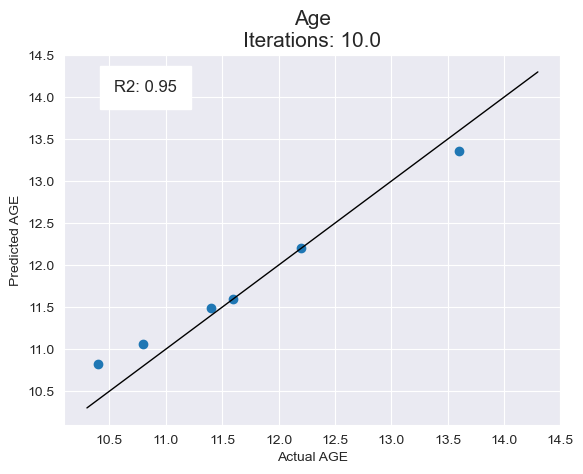

                                           Feature Id  Importances
0                                    DAYS_SINCE_IRRAD    23.272101
1                                  MONTHS_SINCE_IRRAD    17.178474
2                                     ABS_LYMPH_(/uL)    16.158335
3                               Hemaglobin_(HGB_g/dL)     8.551944
4                                                TYPE     8.229269
5                Mean_corpuscular_hemaglobin_(MCH_pg)     8.005325
6                                     LYMPHOCYTES_(%)     5.446214
7                                          WBC_(K/uL)     4.609653
8                                             EOS_(%)     2.790546
9                                    Hemocrit_(HCT_%)     2.551248
10                   Mean_corpuscular_volume_(MCV_fL)     1.620878
11                                           BASO_(%)     0.852428
12                                     ABS_NEUT_(/uL)     0.238839
13                                      ABS_EOS_(/uL)     0.19

In [21]:
regression_pipeline (sreg_df)

# Multi Monkey Predictions, whole data

In [182]:
#make a parent df
minbio_monkey_df.copy()
mreg_df = minbio_monkey_df

#Exclude datetime feautres
mreg_df=mreg_df.drop(['IRRAD_DATE','DOB','SAMPLE_DATE'],axis=1)
mreg_df.head(2)


,ID,Species,IRRAD,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,Rhesus-Chinese,No,F,Clinical,NaN,NaN,NaN,NaN,10.6,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,NaN,10.7,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334


Target Feature Column: LYMPHOCYTES_(%)
How many catagorical columns: 4


iteritems is deprecated and will be removed in a future version. Use .items instead.


Test Size 0.3
Iterations: 10
Learning Rate: 0.5
Stopping Rounds: 5


0:	learn: 8.9546285	total: 5.74ms	remaining: 51.6ms
1:	learn: 5.6638343	total: 10.4ms	remaining: 41.8ms
2:	learn: 4.0121201	total: 15.2ms	remaining: 35.4ms
3:	learn: 3.0209193	total: 19.6ms	remaining: 29.4ms
4:	learn: 2.5326614	total: 24.3ms	remaining: 24.3ms
5:	learn: 2.2299779	total: 29.6ms	remaining: 19.7ms
6:	learn: 2.0293479	total: 34.2ms	remaining: 14.7ms
7:	learn: 1.9160268	total: 36.9ms	remaining: 9.22ms
8:	learn: 1.8753615	total: 39.5ms	remaining: 4.38ms
9:	learn: 1.7568019	total: 42.1ms	remaining: 0us


Plot Title: Multi monkey lymphocytes


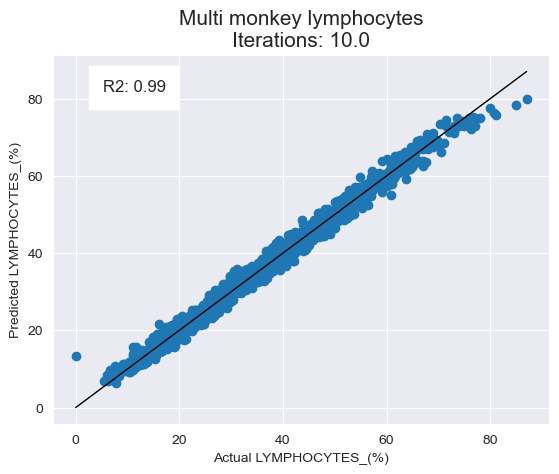

                                           Feature Id  Importances
0                                            NEUT_(%)    86.690265
1                                     ABS_LYMPH_(/uL)     4.309505
2                                      ABS_MONO_(/uL)     2.908496
3                                            MONO_(%)     2.536824
4                                             EOS_(%)     1.749061
5                                       ABS_EOS_(/uL)     0.948118
6                               Hemaglobin_(HGB_g/dL)     0.429481
7                                      ABS_NEUT_(/uL)     0.275921
8                                    Hemocrit_(HCT_%)     0.072630
9                    Mean_corpuscular_volume_(MCV_fL)     0.037872
10                                           BASO_(%)     0.034285
11  Mean_corpuscular_hemaglobin_concentration_(MCH...     0.007542
12                                            Species     0.000000
13                                              IRRAD     0.00

In [186]:
regression_pipeline(mreg_df)


## 1.b.) Prediction of different data
- Using the multi monkey model to predict the single monkey data and vise versa
- Using just the top 5 features to make the models and make the predicitons
- See if using irrad data only can make accurate predictions
- How to make predictions of different features withthout making a new model every time???

Note: see if there is a way to streamline this process - pipelines?

### A. Predicting the single monkey lymphocytes using the multi-monkey model

iteritems is deprecated and will be removed in a future version. Use .items instead.


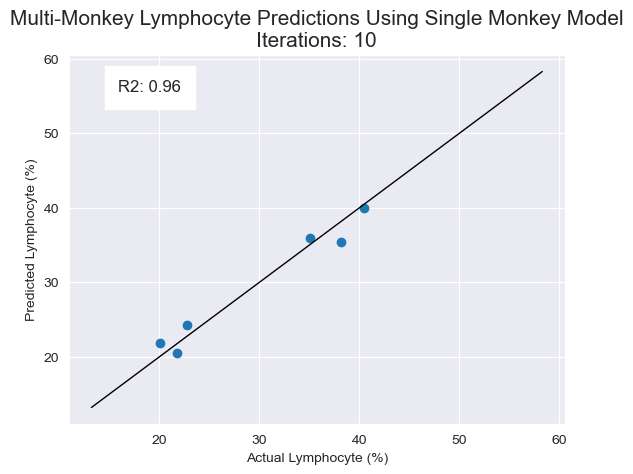

In [164]:
### Predicting the single monkey lymphocyte levels using the mult monkey model

#Model making predicions
smreg_a = model8.predict(sreg_X_validation)
smreg_a_df = pd.DataFrame(smreg_a)


# Plot the predictions
fig, ax = plt.subplots()
ax.scatter(sreg_y_validation, smreg_a_df)

ax.plot([sreg_y.min(), sreg_y.max()], [sreg_y.min(), sreg_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

#Plot axis titles
ax.set_xlabel('Actual Lymphocyte (%)')
ax.set_ylabel('Predicted Lymphocyte (%)')

#Title of the plot
ax.set_title('Multi-Monkey Lymphocyte Predictions Using Single Monkey Model\nIterations: {}'
             .format(model8.get_param('iterations')), 
             fontsize=15
)

xmin, xmax, ymin, ymax = plt.axis()

yrange = ymax-ymin
xrange = xmax-xmin

#Plotting the R2 score
ax.annotate("R2: {}".format(str(r2_score(sreg_y_validation, smreg_a_df).round(2))),
            xy=((xmin+(0.1*(xrange))),(ymax-(0.1*(yrange)))), fontsize=12,
            bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
)

plt.show()

### B. Predicting the multi-monkey lymphocytes using the single-monkey model

iteritems is deprecated and will be removed in a future version. Use .items instead.


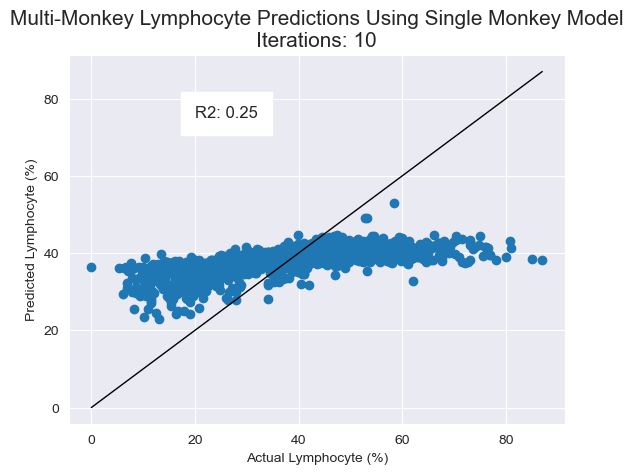

In [45]:
### Predicting if the apropriately fitted single monkey model can predict the multi mokey lymphocytes

#Model making predicions
msreg_a = model7.predict(mreg_X_validation)

msreg_a_df = pd.DataFrame(msreg_a)

#Plot The predictions
fig, ax = plt.subplots()
ax.scatter(mreg_y_validation, msreg_a_df)

ax.plot([mreg_y.min(), mreg_y.max()], [mreg_y.min(), mreg_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

#Plot axis titles
ax.set_xlabel('Actual Lymphocyte (%)')
ax.set_ylabel('Predicted Lymphocyte (%)')

#Title of the plot
ax.set_title('Multi-Monkey Lymphocyte Predictions Using Single Monkey Model\nIterations: {}'
             .format(model7.get_param('iterations')), 
             fontsize=15
)

#Plotting the R2 score
ax.annotate("R2: {}".format(str(r2_score(mreg_y_validation, msreg_a_df).round(2))),
           xy=(20,75), fontsize=12,
            bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
)

plt.show()

In [46]:
### Seeing if more iterations will better predict the multi monkey data
# Model for predicting lymphocyte counts for a singel monkey
model9= CatBoostRegressor(iterations=100000,
    learning_rate=0.5,
    #loss_function='MultiClass',
    #custom_loss=['AUC','Accuracy'],
    early_stopping_rounds=5,
    #use_best_model=True,
    #save_snapshot = True,
    #snapshot_file='monkey_snapshot.bkp',
    #interval is seconds
    #snapshot_interval=120
)


model9.fit(sreg_X, 
           sreg_y, 
           cat_features=cat_features,
           #plot=True,
           verbose=10000 #tells how many iterations to print
         )

iteritems is deprecated and will be removed in a future version. Use .items instead.


0:	learn: 11.2460441	total: 671us	remaining: 1m 7s
10000:	learn: 0.0000000	total: 3.91s	remaining: 35.2s
20000:	learn: 0.0000000	total: 7.03s	remaining: 28.1s
30000:	learn: 0.0000000	total: 10.1s	remaining: 23.6s
40000:	learn: 0.0000000	total: 13.2s	remaining: 19.8s
50000:	learn: 0.0000000	total: 16.1s	remaining: 16.1s
60000:	learn: 0.0000000	total: 19.2s	remaining: 12.8s
70000:	learn: 0.0000000	total: 22.3s	remaining: 9.54s
80000:	learn: 0.0000000	total: 25.2s	remaining: 6.29s
90000:	learn: 0.0000000	total: 28s	remaining: 3.11s
99999:	learn: 0.0000000	total: 30.8s	remaining: 0us


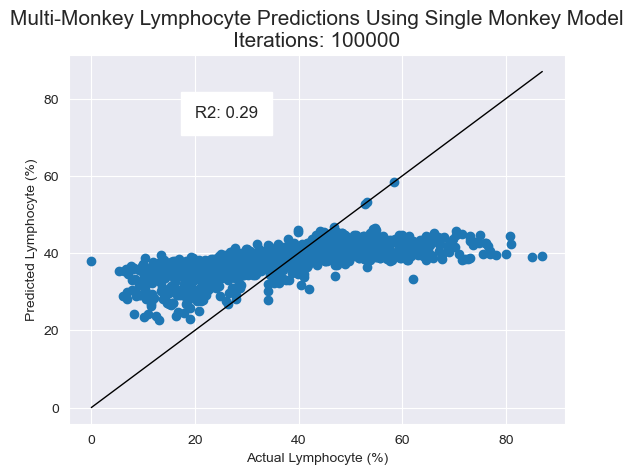

In [47]:
### Predicting the multi monkey lymphocytes using the single monkey overfitted model

#Model making predicions
msreg_a = model9.predict(mreg_X_validation)
msreg_a_df = pd.DataFrame(msreg_a)

#Plot The predictions
fig, ax = plt.subplots()
ax.scatter(mreg_y_validation, msreg_a_df)

ax.plot([mreg_y.min(), mreg_y.max()], [mreg_y.min(), mreg_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

#Plot axis titles
ax.set_xlabel('Actual Lymphocyte (%)')
ax.set_ylabel('Predicted Lymphocyte (%)')

#Title of the plot
ax.set_title('Multi-Monkey Lymphocyte Predictions Using Single Monkey Model\nIterations: {}'
             .format(model9.get_param('iterations')), 
             fontsize=15
)

#Plotting the R2 score
ax.annotate("R2: {}".format(str(r2_score(mreg_y_validation, msreg_a_df).round(2))),
           xy=(20,75), fontsize=12,
            bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
)

plt.show()

### C. Predictions using only the top 5 important features
top 5 features found in section 1.a. Using the top 5 features found from each model (single v. multi monkey)

### Single Monkey:
Top 5 features: 
- 0 NEUT_(%)	26.502043
- 1	TYPE	12.952220
- 2	ABS_LYMPH_(/uL)	12.820068
- 3	EOS_(%)	11.754037
- 4	RBC_(M/uL)	11.554449


#### Data Processing

In [48]:
### Make the reduced df

#make a parent df
single_minbio_df.copy()
sred_reg_df = single_minbio_df[['ID', 'TYPE', 'NEUT_(%)', 'ABS_LYMPH_(/uL)',
                                'EOS_(%)','RBC_(M/uL)', 'LYMPHOCYTES_(%)']]
sred_reg_df.tail(2)


,ID,TYPE,NEUT_(%),ABS_LYMPH_(/uL),EOS_(%),RBC_(M/uL),LYMPHOCYTES_(%)
49,2046,Clinical,36.9,5130,0.2,6.55,58.3
50,2046,Research,45.9,3897,0.3,5.56,52.8


In [49]:
### Process data for ML
#make train/testdf
(sred_reg_train_df, sred_reg_test_df)= sred_reg_df, sred_reg_df

#sreg_test_df.tail(2)

# label values extraction
sred_reg_y=sred_reg_train_df['LYMPHOCYTES_(%)']
sred_reg_X=sred_reg_train_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)

#reg_y.tail()
#sred_reg_X.columns

#sred_reg_y.to_numpy()

# Declare catagorical features - first column
cat_features= list(range(0,sred_reg_X[sred_reg_X.columns[:1]].shape[1]))

print(cat_features)

# all of our labels are catagorical

#put the data into the pool
sred_reg_pool = Pool(data=sred_reg_X, label=sred_reg_y, cat_features=cat_features)


#train tesr split - 30% test
sred_reg_data= train_test_split(sred_reg_X, sred_reg_y, test_size=0.3, random_state=0)

#### The order of this matters###
sred_reg_X_train, sred_reg_X_validation, sred_reg_y_train, sred_reg_y_validation= sred_reg_data

sred_reg_train_pool = Pool(
    data = sred_reg_X_train,
    label = sred_reg_y_train,
    cat_features = cat_features
)

sred_reg_validation_pool = Pool(
    data = sred_reg_X_validation,
    label = sred_reg_y_validation,
    cat_features = cat_features
)



[0]


iteritems is deprecated and will be removed in a future version. Use .items instead.


#### Model Formation

In [209]:
### Making a model with the same perameters but with only the top 5 important features
# rEgression for multiple monkey predicitons
model10= CatBoostRegressor(iterations=4,
    learning_rate=0.5,
    #loss_function='MultiClass',
    #custom_loss=['AUC','Accuracy'],
    early_stopping_rounds=5,
    #use_best_model=True,
    #save_snapshot = True,
    #snapshot_file='monkey_snapshot.bkp',
    #interval is seconds
    #snapshot_interval=120
)

model10.fit(sred_reg_X, 
           sred_reg_y, 
           cat_features=cat_features, 
          # verbose=100 #tells how many iterations to print
         )


0:	learn: 10.8658171	total: 228us	remaining: 684us
1:	learn: 8.3596623	total: 366us	remaining: 366us
2:	learn: 7.1663548	total: 554us	remaining: 184us
3:	learn: 6.1039802	total: 732us	remaining: 0us


#### Predictions

iteritems is deprecated and will be removed in a future version. Use .items instead.


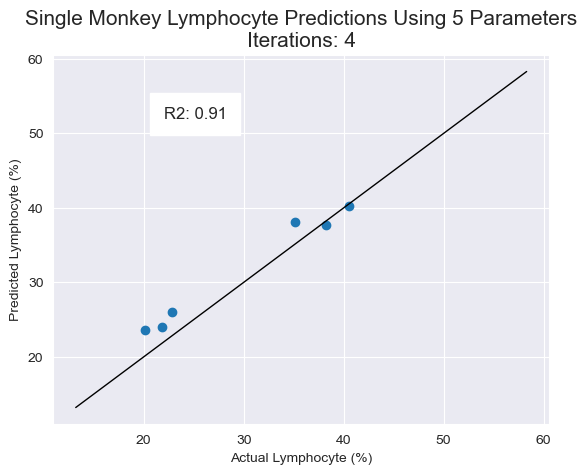

In [234]:
### Predicting the single monkey lymphocyte levels using the top 5 parameters

#Model making predicions
sred_reg_a = model10.predict(sred_reg_X_validation)
sred_reg_a_df = pd.DataFrame(sred_reg_a)

#Plot The predictions
fig, ax = plt.subplots()
ax.scatter(sred_reg_y_validation, sred_reg_a_df)

ax.plot([sred_reg_y.min(), sred_reg_y.max()], [sred_reg_y.min(), sred_reg_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

#Plot axis titles
ax.set_xlabel('Actual Lymphocyte (%)')
ax.set_ylabel('Predicted Lymphocyte (%)')

#Title of the plot
ax.set_title('Single Monkey Lymphocyte Predictions Using 5 Parameters\nIterations: {}'
             .format(model10.get_param('iterations')), 
             fontsize=15
)

#Plotting the R2 score
ax.annotate("R2: {}".format(str(r2_score(sred_reg_y_validation, sred_reg_a_df).round(2))),
           xy=(22,52), fontsize=12,
            bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
)

plt.show()

### Multi Monkey
Top 5 features:
- 0 NEUT_(%)	92.324836
- 1	ABS_LYMPH_(/uL)	3.185803
- 2	ABS_MONO_(/uL)	2.682848
-  3	EOS_(%)	1.198216
- 4	Hemaglobin_(HGB_g/dL)	0.559005

Also try with just NEUT_(%) since it is so heavily weighted

#### Data Processing

In [218]:
### Make the reduced df

#make a parent df
minbio_monkey_df.copy()
mred_reg_df = minbio_monkey_df[['ID', 'ABS_MONO_(/uL)', 'NEUT_(%)', 'ABS_LYMPH_(/uL)',
                                'EOS_(%)','Hemaglobin_(HGB_g/dL)', 'LYMPHOCYTES_(%)']]
mred_reg_df.tail(2)


,ID,ABS_MONO_(/uL),NEUT_(%),ABS_LYMPH_(/uL),EOS_(%),Hemaglobin_(HGB_g/dL),LYMPHOCYTES_(%)
4550,2210,632,51.2,2100,1.7,13.2,36.2
4551,2210,1176,60.0,896,3.0,13.2,16.0


In [219]:
### Process data for ML
#make train/testdf
(mred_reg_train_df, mred_reg_test_df)= mred_reg_df, mred_reg_df


# label values extraction
mred_reg_y=mred_reg_train_df['LYMPHOCYTES_(%)']
mred_reg_X=mred_reg_train_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)


# Declare catagorical features - first & second column
cat_features= list(range(0,mred_reg_X[mred_reg_X.columns[:1]].shape[1]))

print(cat_features)


#put the data into the pool
mred_reg_pool = Pool(data=mred_reg_X, label=mred_reg_y, cat_features=cat_features)


#train tesr split - 30% test
mred_reg_data= train_test_split(mred_reg_X, mred_reg_y, test_size=0.3, random_state=0)

#### The order of this matters###
mred_reg_X_train, mred_reg_X_validation, mred_reg_y_train, mred_reg_y_validation= mred_reg_data

mred_reg_train_pool = Pool(
    data = mred_reg_X_train,
    label = mred_reg_y_train,
    cat_features = cat_features
)

mred_reg_validation_pool = Pool(
    data = mred_reg_X_validation,
    label = mred_reg_y_validation,
    cat_features = cat_features
)



[0]


iteritems is deprecated and will be removed in a future version. Use .items instead.


#### Model Formation

In [220]:
### Making a model with the same perameters but with only the top 5 important features
# regression for multiple monkey predicitons
model11= CatBoostRegressor(iterations=2,
    learning_rate=0.5,
    #loss_function='MultiClass',
    #custom_loss=['AUC','Accuracy'],
    early_stopping_rounds=5,
    #use_best_model=True,
    #save_snapshot = True,
    #snapshot_file='monkey_snapshot.bkp',
    #interval is seconds
    #snapshot_interval=120
)

model11.fit(mred_reg_X, 
           mred_reg_y, 
           cat_features=cat_features, 
          # verbose=100 #tells how many iterations to print
         )


0:	learn: 9.0561659	total: 2.21ms	remaining: 2.21ms
1:	learn: 5.6939955	total: 4.5ms	remaining: 0us


#### Predicting multi-monkey lymphocytes

iteritems is deprecated and will be removed in a future version. Use .items instead.


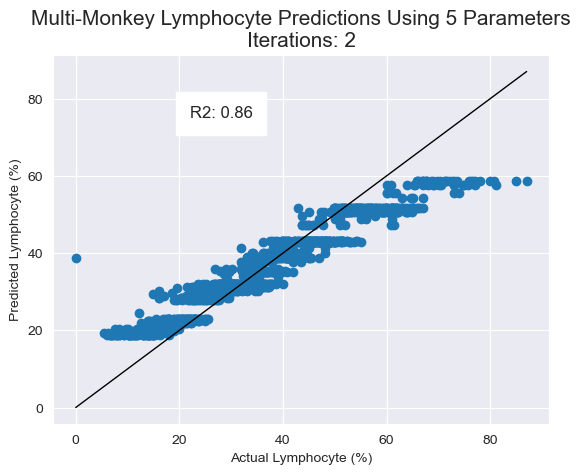

In [233]:
### Predicting the multi monkey lymphocyte levels using top 5 parameters

#Model making predicions
mred_reg_a = model11.predict(mred_reg_X_validation)
mred_reg_a_df = pd.DataFrame(mred_reg_a)

#Plot The predictions
fig, ax = plt.subplots()
ax.scatter(mred_reg_y_validation, mred_reg_a_df)

ax.plot([mred_reg_y.min(), mred_reg_y.max()], [mred_reg_y.min(), mred_reg_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

#Plot axis titles
ax.set_xlabel('Actual Lymphocyte (%)')
ax.set_ylabel('Predicted Lymphocyte (%)')

#Title of the plot
ax.set_title('Multi-Monkey Lymphocyte Predictions Using 5 Parameters\nIterations: {}'
             .format(model11.get_param('iterations')), 
             fontsize=15
)

#Plotting the R2 score
ax.annotate("R2: {}".format(str(r2_score(mred_reg_y_validation, mred_reg_a_df).round(2))),
           xy=(22,75), fontsize=12,
            bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
)


plt.show()

#### Predicting single-monkey lymphocytes
Needs the same features to directly compare

In [78]:
### Predicting the single monkey lymphocyte levels using the mult monkey model
## 2 iteration, 0.5 learning rate

smred_reg_a = model11.predict(sred_reg_X_validation)
print(len(smred_reg_a), 
     )
smred_reg_a_df = pd.DataFrame(smred_reg_a)
#print(sred_reg_a_df)
#print(sred_reg_y_validation)

#r2 is the best metric for accuracy of predictions with continuous data
#print('The r2 score for the model is:',r2_score(sreg_y_validation, smreg_a_df))

# Plot the predictions vs. actual with the R2 score

fig, ax = plt.subplots()
ax.scatter(sred_reg_y_validation, smred_reg_a_df)


ax.plot([sred_reg_y.min(), sred_reg_y.max()], [sred_reg_y.min(), sred_reg_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

ax.set_xlabel('Actual Lymphocyte (%)')
ax.set_ylabel('Predicted Lymphocyte (%)')
#regression line
#single_y_validation, single_a_df = single_y_validation.reshape(-1,1), single_a_df.reshape(-1,1)
#ax.plot(single_y_validation, LinearRegression().fit(single_y_validation, single_a_df).predict(single_y_validation))



ax.set_title('R2: ' + str(r2_score(sred_reg_y_validation, smred_reg_a_df)))

plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:81: At position 4 should be feature with name Hemaglobin_(HGB_g/dL) (found RBC_(M/uL)).

### D. Predicting lymphocytes with only the irradiation data


#### Multi Monkey only
No variation for single monkey model formation

##### Data processing

In [79]:
### Make the reduced df

#make a parent df
minbio_monkey_df.copy()
mrad_reg_df = minbio_monkey_df[['ID', 'IRRAD', 'SEX', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'LYMPHOCYTES_(%)']]
mrad_reg_df.tail(2)


,ID,IRRAD,SEX,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,LYMPHOCYTES_(%)
4550,2210,No,F,NaN,NaN,NaN,NaN,25.5,36.2
4551,2210,No,F,NaN,NaN,NaN,NaN,22.8,16.0


In [80]:
### Process data for ML
#make train/testdf
(mrad_reg_train_df, mrad_reg_test_df)= mrad_reg_df, mrad_reg_df


# label values extraction
mrad_reg_y=mrad_reg_train_df['LYMPHOCYTES_(%)']
mrad_reg_X=mrad_reg_train_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)


# Declare catagorical features - first & second column
cat_features= list(range(0,mrad_reg_X[mrad_reg_X.columns[:2]].shape[1]))

print(cat_features)


#put the data into the pool
mrad_reg_pool = Pool(data=mrad_reg_X, label=mrad_reg_y, cat_features=cat_features)


#train tesr split - 30% test
mrad_reg_data= train_test_split(mrad_reg_X, mrad_reg_y, test_size=0.3, random_state=0)

#### The order of this matters###
mrad_reg_X_train, mrad_reg_X_validation, mrad_reg_y_train, mrad_reg_y_validation= mrad_reg_data

mrad_reg_train_pool = Pool(
    data = mrad_reg_X_train,
    label = mrad_reg_y_train,
    cat_features = cat_features
)

mrad_reg_validation_pool = Pool(
    data = mrad_reg_X_validation,
    label = mrad_reg_y_validation,
    cat_features = cat_features
)



[0, 1]


iteritems is deprecated and will be removed in a future version. Use .items instead.


##### Model Formation

In [81]:
### Making a model with the same perameters but with only the top 5 important features
# regression for multiple monkey predicitons
model12= CatBoostRegressor(iterations=1000,
    learning_rate=0.5,
    #loss_function='MultiClass',
    #custom_loss=['AUC','Accuracy'],
    early_stopping_rounds=5,
    #use_best_model=True,
    #save_snapshot = True,
    #snapshot_file='monkey_snapshot.bkp',
    #interval is seconds
    #snapshot_interval=120
)

model12.fit(mrad_reg_X, 
           mrad_reg_y, 
           cat_features=cat_features, 
           verbose=100 #tells how many iterations to print
         )
### 2 iters gives R2 = 0.12
### 10 iters gives R2 = 0.2
### 100 iters gives R2 = 0.4
### 1000 iters gives R2 = 0.73

0:	learn: 14.8524382	total: 2.48ms	remaining: 2.48s
100:	learn: 11.4650605	total: 364ms	remaining: 3.24s
200:	learn: 10.4762500	total: 499ms	remaining: 1.98s
300:	learn: 9.8396659	total: 621ms	remaining: 1.44s
400:	learn: 9.3452165	total: 726ms	remaining: 1.08s
500:	learn: 8.9539214	total: 825ms	remaining: 822ms
600:	learn: 8.6488356	total: 927ms	remaining: 615ms
700:	learn: 8.4305616	total: 1.03s	remaining: 439ms
800:	learn: 8.2397296	total: 1.13s	remaining: 280ms
900:	learn: 8.0563111	total: 1.23s	remaining: 135ms
999:	learn: 7.9163296	total: 1.34s	remaining: 0us


##### Predicting multi-monkey lymphocytes

1366


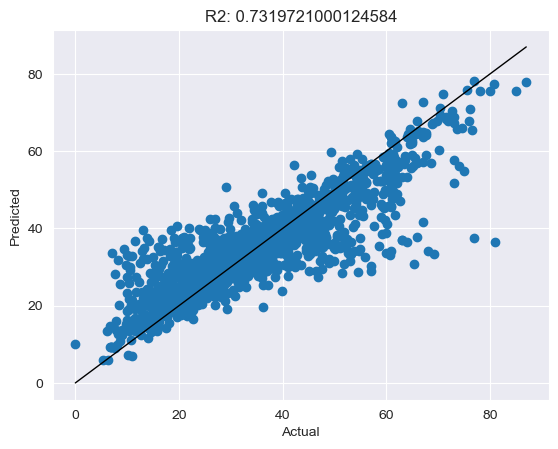

In [82]:
### Predicting the single monkey lymphocyte levels using the mult monkey model
## 1000 iteration, 0.5 learning rate

mrad_reg_a = model12.predict(mrad_reg_X_validation)
print(len(mrad_reg_a), 
     )
mrad_reg_a_df = pd.DataFrame(mrad_reg_a)


# Plot the predictions vs. actual with the R2 score
fig, ax = plt.subplots()
ax.scatter(mrad_reg_y_validation, mrad_reg_a_df)


ax.plot([mrad_reg_y.min(), mrad_reg_y.max()], [mrad_reg_y.min(), mrad_reg_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

ax.set_xlabel('Actual Lymphocyte (%)')
ax.set_ylabel('Predicted Lymphocyte (%)')
#regression line
#single_y_validation, single_a_df = single_y_validation.reshape(-1,1), single_a_df.reshape(-1,1)
#ax.plot(single_y_validation, LinearRegression().fit(single_y_validation, single_a_df).predict(single_y_validation))



ax.set_title('R2: ' + str(r2_score(mrad_reg_y_validation, mrad_reg_a_df)))

plt.show()

##### Predicting single-monkey lymphocytes

In [83]:
### Make the reduced df

#make a parent df
single_minbio_df.copy()
srad_reg_df = single_minbio_df[['ID', 'IRRAD', 'SEX', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'LYMPHOCYTES_(%)']]
srad_reg_df.tail(2)

,ID,IRRAD,SEX,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,LYMPHOCYTES_(%)
49,2046,Yes,F,2570.0,84.0,81.0,1.14,13.8,58.3
50,2046,Yes,F,2738.0,90.0,81.0,1.14,14.3,52.8


In [84]:
### Process data for ML
#make train/testdf
(srad_reg_train_df, srad_reg_test_df)= srad_reg_df, srad_reg_df


# label values extraction
srad_reg_y=srad_reg_train_df['LYMPHOCYTES_(%)']
srad_reg_X=srad_reg_train_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)


# Declare catagorical features - first & second column
cat_features= list(range(0,srad_reg_X[srad_reg_X.columns[:2]].shape[1]))

print(cat_features)


#put the data into the pool
srad_reg_pool = Pool(data=srad_reg_X, label=srad_reg_y, cat_features=cat_features)


#train tesr split - 30% test
srad_reg_data= train_test_split(srad_reg_X, srad_reg_y, test_size=0.3, random_state=0)

#### The order of this matters###
srad_reg_X_train, srad_reg_X_validation, srad_reg_y_train, srad_reg_y_validation= srad_reg_data

srad_reg_train_pool = Pool(
    data = srad_reg_X_train,
    label = srad_reg_y_train,
    cat_features = cat_features
)

srad_reg_validation_pool = Pool(
    data = srad_reg_X_validation,
    label = srad_reg_y_validation,
    cat_features = cat_features
)



[0, 1]


iteritems is deprecated and will be removed in a future version. Use .items instead.


6


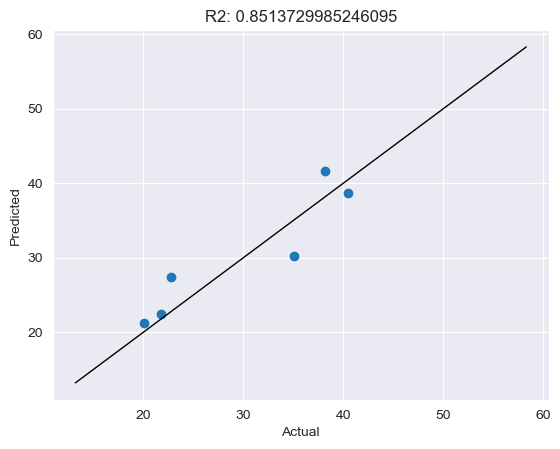

In [85]:
### Predicting the single monkey lymphocyte levels using the mult monkey model
## 1000 iteration, 0.5 learning rate

smrad_reg_a = model12.predict(srad_reg_X_validation)
print(len(smrad_reg_a), 
     )
smrad_reg_a_df = pd.DataFrame(smrad_reg_a)


# Plot the predictions vs. actual with the R2 score
fig, ax = plt.subplots()
ax.scatter(srad_reg_y_validation, smrad_reg_a_df)


ax.plot([srad_reg_y.min(), srad_reg_y.max()], [srad_reg_y.min(), srad_reg_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

ax.set_xlabel('Actual Lymphocyte (%)')
ax.set_ylabel('Predicted Lymphocyte (%)')
#regression line
#single_y_validation, single_a_df = single_y_validation.reshape(-1,1), single_a_df.reshape(-1,1)
#ax.plot(single_y_validation, LinearRegression().fit(single_y_validation, single_a_df).predict(single_y_validation))



ax.set_title('R2: ' + str(r2_score(srad_reg_y_validation, smrad_reg_a_df)))

plt.show()

### E. Predictions with data that excludes the individual
See if excluding the target individual from the dataset still gives accurate predictions

#### Data Processing

In [86]:
### setting up the multi monkey df without the single monkey 
oneless_df.tail(2)


,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
4532,2210,Rhesus-Indian,2021-09-20 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,36.2,10.9,1.7,0.0,2970,2100,632,99,0,348
4533,2210,Rhesus-Indian,2021-10-07 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,16.0,21.0,3.0,0.0,3360,896,1176,168,0,329


In [87]:
### Processing the data for ML
### Process data for ML
#make train/testdf
(oneless_train_df, oneless_test_df)= oneless_df, oneless_df


# label values extraction
oneless_y=oneless_train_df['LYMPHOCYTES_(%)']
oneless_X=oneless_train_df.drop(['ID','IRRAD_DATE','DOB','SAMPLE_DATE','LYMPHOCYTES_(%)'],axis=1)


# Declare catagorical features - first & second column
cat_features= list(range(0,oneless_X[oneless_X.columns[:4]].shape[1]))

print(cat_features)


#put the data into the pool
oneless_pool = Pool(data=oneless_X, label=oneless_y, cat_features=cat_features)


#train tesr split - 30% test
oneless_data= train_test_split(oneless_X, oneless_y, test_size=0.3, random_state=0)

#### The order of this matters###
oneless_X_train, oneless_X_validation, oneless_y_train, oneless_y_validation= oneless_data

oneless_train_pool = Pool(
    data = oneless_X_train,
    label = oneless_y_train,
    cat_features = cat_features
)

oneless_validation_pool = Pool(
    data = oneless_X_validation,
    label = oneless_y_validation,
    cat_features = cat_features
)


[0, 1, 2, 3]


iteritems is deprecated and will be removed in a future version. Use .items instead.


#### Model Formation

In [88]:
### Making a model with the same perameters but without the single monkey data
# regression for multiple monkey predicitons
model13= CatBoostRegressor(iterations=2,
    learning_rate=0.5,
    #loss_function='MultiClass',
    #custom_loss=['AUC','Accuracy'],
    early_stopping_rounds=5,
    #use_best_model=True,
    #save_snapshot = True,
    #snapshot_file='monkey_snapshot.bkp',
    #interval is seconds
    #snapshot_interval=120
)

model13.fit(oneless_X, 
           oneless_y, 
           cat_features=cat_features, 
           verbose=100 #tells how many iterations to print
         )
### 2 iters gives R2 = 0.12


0:	learn: 9.6225247	total: 8.9ms	remaining: 8.9ms
1:	learn: 6.0610900	total: 15.3ms	remaining: 0us


#### Predictions
Just predicting the single monkey data in this case

6


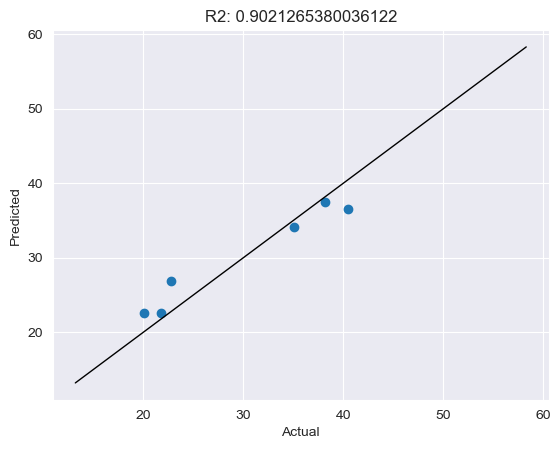

In [89]:
### Predicting the single monkey lymphocyte levels using the mult monkey minus single model
## 2 iteration, 0.5 learning rate

onless_a = model13.predict(sreg_X_validation)
print(len(onless_a), 
     )
onless_a_df = pd.DataFrame(onless_a)


# Plot the predictions vs. actual with the R2 score
fig, ax = plt.subplots()
ax.scatter(sreg_y_validation, onless_a_df)


ax.plot([sreg_y.min(), sreg_y.max()], [sreg_y.min(), sreg_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

ax.set_xlabel('Actual Lymphocyte (%)')
ax.set_ylabel('Predicted Lymphocyte (%)')
#regression line
#single_y_validation, single_a_df = single_y_validation.reshape(-1,1), single_a_df.reshape(-1,1)
#ax.plot(single_y_validation, LinearRegression().fit(single_y_validation, single_a_df).predict(single_y_validation))



ax.set_title('R2: ' + str(r2_score(sreg_y_validation, onless_a_df)))

plt.show()

### Summary
- A.) A single monkey's lymphocyte levels can be accurately predicted (R2=0.85) using the model trained on all the monkeys.
- B.) A single monkey's model does not accurately predict the other monkey's lymphocyte counts
- C.) Only using the top 5 important features for each model gives highly accurate predictions (R2=0.85-0.91) but the multi-monkey model was unable to predict the single monkey lymphocyte levels because the model needs the same features between the datasets and they were different (different top 5 features)
- D.) Only using the non-timeseries, radiation-related data was abel to accurately predict the multi-monkey lymphocyte levels (R2=0.73) and the single monkey lymphocyte levels (R2=0.85). I only trained a multi monkey model because there would be no variance for a single monkey model
- E.) A single monkey's lymphocyte levels were accurately predicted (R2=0.902) using a model trained on data that did not include the single monkey's data. In fact, the "oneless" model predicted more accurately than when using all the data (R2=0.855)

What does this mean? That an individuals biomarker levels can be very accurately predicted using models that take little energy and time. Additionally, that the individual doesn't need to be part of the collected data (they can be novel). Furthermore, a very small amount of data can make accurate predictions, and non-datetime irradiation (with sex and age) data can be used to make accurate predictions. 

## 1.c. Predictions of the health data (tumorogenesis)
Doesn't make sense to predict or use single monkey moels/data becuase there is only one observation per monkey

# HEALTH OUTCOME PIPELINE

In [43]:
def classifier_pipeline (df):
    ##################### for this to work, the catagorical features need to be all to the left side of the df ####################
    
    ### Data Setup ###
    
    (train_df, test_df)= df, df 
    
    #data labeling
    ylabel = input('Target Feature Column:')  
    y = df[ylabel]
    X = df.drop(['ID',ylabel],axis=1)
    
    #declare catagorical features
    cat_cols = int(input('How many catagorical columns:'))
    cat_features= list(range(0,X[X.columns[:cat_cols]].shape[1]))
    
    #put data into pool
    pool = Pool(data=X, label=y, cat_features=cat_features)
    
    #train tesr split - 30% test
    test_size = float(input('Test Size'))
    data= train_test_split(X, y, test_size=test_size, random_state=0)

    #The order of this matters#
    X_train, X_validation, y_train, y_validation= data

    train_pool = Pool(
        data = X_train,
        label = y_train,
        cat_features = cat_features
    )

    validation_pool = Pool(
        data = X_validation,
        label = y_validation,
        cat_features = cat_features
    )
    
    ### Model Formation ###
    iterations = float(input('Iterations:'))
    learning_rate = float(input('Learning Rate:'))
    early_stopping_rounds = float(input('Stopping Rounds:'))
    
    model = CatBoostClassifier(iterations=iterations, 
                              learning_rate=learning_rate,
                               loss_function='Logloss',
                               custom_loss=['AUC','Accuracy'],
                               early_stopping_rounds= early_stopping_rounds
    )
   

    model.fit(X, y, 
              cat_features=cat_features, 
              verbose=False  
    )

    ### Predictions ###
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)

    ### Plotting ###
    # make confusion matrix
    cm = confusion_matrix(y_validation, a_df)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  #display_labels=clf.classes_
                                 )
    
    disp.plot()
    plt.grid(False)


    Accuracy = metrics.accuracy_score(y_validation, a_df)
    Precision = metrics.precision_score(y_validation, a_df)

    print('Accuracy:',Accuracy, 'Precision:',Precision)
    print(classification_report(y_validation, a_df))

### Data forming

In [29]:
minhealth_monkey_df.head(2)

,ID,Time_Under_Observation_(yrs),Dose_(Gy),Irrad_Age_(months),Years_Since_Irrad,Current_Age_(years),Animal_Status,Diabetes_(Y/N),Cataracts_(Y/N),Arthritis_(Y/N),...,Hypertension_(Y/N),Testicular Atrophy_(Y/N),Ovarian Dysfunction_(Y/N),Hepatic_(Y/N),Kidney_(Y/N),Lung_(Y/N),Bone_(Y/N),Overweight_(Y/N),Underweight_(Y/N),Brain Lesion_(Y/N)
0,1423,1.380822,0.0,NaN,NaN,9.947945,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,1484,11.868493,0.0,NaN,NaN,19.276712,1,0,1,1,...,0,0,0,0,0,1,0,1,0,0


### A. Predicting single monkey tumorogenesis using the multi-monkey model

### B. Predictions using only the top 5 features

#### Multi Monkey
- 0. Dose_(Gy)	14.984810
- 1	Heart_(Y/N)	14.908153
- 2	Time_Under_Observation_(yrs)	13.851867
- 3	Overweight_(Y/N)	11.484527
- 4	Years_Since_Irrad	11.038610

##### Data processing

Target Feature Column: Tumor_(Y/N)
How many catagorical columns: 0


iteritems is deprecated and will be removed in a future version. Use .items instead.


Test Size 0.3
Iterations: 200
Learning Rate: 0.5
Stopping Rounds: 5


Accuracy: 1.0 Precision: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00         9

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46



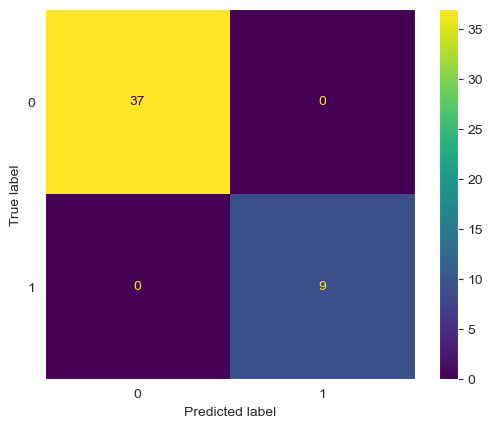

In [44]:
### Make the reduced df

#make a parent df
minhealth_monkey_df.copy()
five_health_df = minhealth_monkey_df[['ID', 'Dose_(Gy)', 'Heart_(Y/N)', 'Time_Under_Observation_(yrs)',
                                'Overweight_(Y/N)','Years_Since_Irrad', 'Tumor_(Y/N)']]

classifier_pipeline (five_health_df)

### C. Predicting Tumorogenesis with only the radiation data

##### Data processing

Target Feature Column: Tumor_(Y/N)
How many catagorical columns: 0


iteritems is deprecated and will be removed in a future version. Use .items instead.


Test Size 0.3
Iterations: 200
Learning Rate: 0.5
Stopping Rounds: 5


Accuracy: 1.0 Precision: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00         9

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46



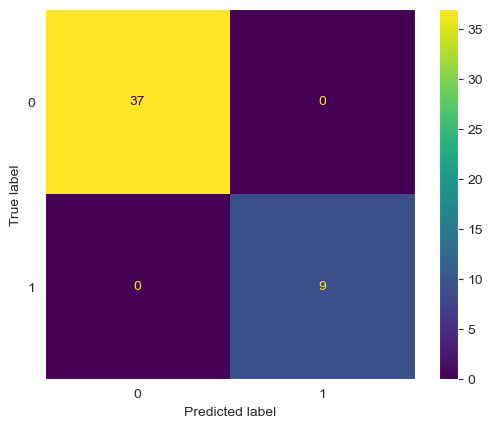

In [45]:
### Make the reduced df

#make a parent df
minhealth_monkey_df.copy()
rad_health_df = minhealth_monkey_df[['ID', 'Dose_(Gy)', 'Irrad_Age_(months)',
                                           'Years_Since_Irrad', 'Current_Age_(years)', 'Tumor_(Y/N)']]

classifier_pipeline (rad_health_df)

Target Feature Column: Testicular Atrophy_(Y/N)
How many catagorical columns: 0


iteritems is deprecated and will be removed in a future version. Use .items instead.


Test Size 0.3
Iterations: 200
Learning Rate: 0.5
Stopping Rounds: 5


Accuracy: 1.0 Precision: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        25

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46



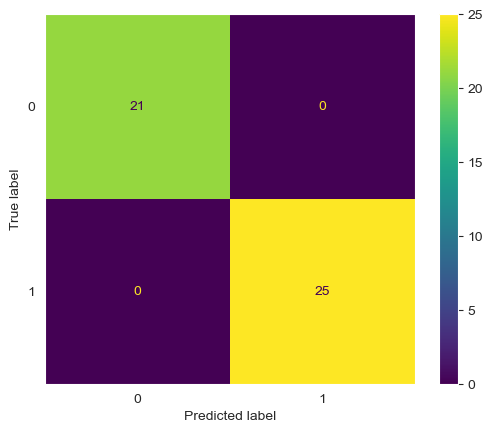

In [47]:
minhealth_monkey_df.head()

classifier_pipeline (minhealth_monkey_df)

## 1.d. Predicting dose 

#### Data Processing

In [105]:
#make single monkey
single_minbio_df.copy()
single_dose_df = single_minbio_df

#fill na values to 0
single_dose_df[['DOSE_(Gy)']]= single_dose_df[['DOSE_(Gy)']].fillna(0, #inplace=True
)



#make multi monkey df
minbio_monkey_df.copy()
dose_df = minbio_monkey_df

#fill na values to 0
dose_df[['DOSE_(Gy)']]= dose_df[['DOSE_(Gy)']].fillna(0, #inplace=True
)

dose_df['DOSE_(Gy)']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4547    0.0
4548    0.0
4549    0.0
4550    0.0
4551    0.0
Name: DOSE_(Gy), Length: 4552, dtype: float64

In [106]:
##### Multi Monkey ####

### Processing the data for ML

#make train/testdf
(dose_train_df, dose_test_df)= dose_df, dose_df


# label values extraction
dose_y=dose_train_df['DOSE_(Gy)']
dose_X=dose_train_df.drop(['ID','IRRAD_DATE','DOB','SAMPLE_DATE','DOSE_(Gy)'],axis=1)


# Declare catagorical features - first & second column
cat_features= list(range(0,dose_X[dose_X.columns[:4]].shape[1]))

print(cat_features)


#put the data into the pool
dose_pool = Pool(data=dose_X, label=dose_y, cat_features=cat_features)


#train tesr split - 30% test
dose_data= train_test_split(dose_X, dose_y, test_size=0.3, random_state=0)

#### The order of this matters###
dose_X_train, dose_X_validation, dose_y_train, dose_y_validation= dose_data

dose_train_pool = Pool(
    data = dose_X_train,
    label = dose_y_train,
    cat_features = cat_features
)

dose_validation_pool = Pool(
    data = dose_X_validation,
    label = dose_y_validation,
    cat_features = cat_features
)


[0, 1, 2, 3]


iteritems is deprecated and will be removed in a future version. Use .items instead.


In [107]:
##### Multi Monkey ####

### Processing the data for ML

#make train/testdf
(single_dose_train_df, single_dose_test_df)= single_dose_df, single_dose_df


# label values extraction
single_dose_y=single_dose_train_df['DOSE_(Gy)']
single_dose_X=single_dose_train_df.drop(['ID','IRRAD_DATE','DOB','SAMPLE_DATE','DOSE_(Gy)'],axis=1)


# Declare catagorical features - first & second column
cat_features= list(range(0,single_dose_X[single_dose_X.columns[:4]].shape[1]))

print(cat_features)


#put the data into the pool
single_dose_pool = Pool(data=single_dose_X, label=single_dose_y, cat_features=cat_features)


#train tesr split - 30% test
single_dose_data= train_test_split(single_dose_X, single_dose_y, test_size=0.3, random_state=0)

#### The order of this matters###
single_dose_X_train, single_dose_X_validation, single_dose_y_train, single_dose_y_validation= single_dose_data

single_dose_train_pool = Pool(
    data = single_dose_X_train,
    label = single_dose_y_train,
    cat_features = cat_features
)

single_dose_validation_pool = Pool(
    data = single_dose_X_validation,
    label = single_dose_y_validation,
    cat_features = cat_features
)


[0, 1, 2, 3]


iteritems is deprecated and will be removed in a future version. Use .items instead.


#### Model Formation

In [108]:
### Making a model with the same perameters but without the single monkey data
# regression for multiple monkey predicitons
dose_model= CatBoostRegressor(iterations=100,
    learning_rate=0.5,
    #loss_function='MultiClass',
    #custom_loss=['AUC','Accuracy'],
    early_stopping_rounds=5,
    #use_best_model=True,
    #save_snapshot = True,
    #snapshot_file='monkey_snapshot.bkp',
    #interval is seconds
    #snapshot_interval=120
)

dose_model.fit(dose_X, 
           dose_y, 
           cat_features=cat_features, 
           verbose=100 #tells how many iterations to print
         )
### 2 iters gives R2 = 0.78 but way off
### 10 gives R2 = 0.92 but still funky
### 100 gives R2 = 0.98 and looking better

0:	learn: 1.8015170	total: 7.91ms	remaining: 783ms
99:	learn: 0.3432601	total: 409ms	remaining: 0us


#### Predictions


##### Multi Monkey Predictions

1366


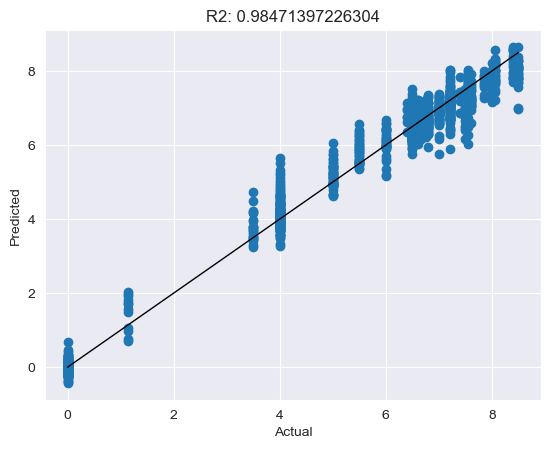

In [109]:
### Predicting the single monkey dose levels
## 2 iteration, 0.5 learning rate

dose_a = dose_model.predict(dose_X_validation)
print(len(dose_a), 
     )
dose_a_df = pd.DataFrame(dose_a)


# Plot the predictions vs. actual with the R2 score
fig, ax = plt.subplots()
ax.scatter(dose_y_validation, dose_a_df)


ax.plot([dose_y.min(), dose_y.max()], [dose_y.min(), dose_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

ax.set_xlabel('Actual Dose (Gy)')
ax.set_ylabel('Predicted Dose (Gy)')
#regression line
#single_y_validation, single_a_df = single_y_validation.reshape(-1,1), single_a_df.reshape(-1,1)
#ax.plot(single_y_validation, LinearRegression().fit(single_y_validation, single_a_df).predict(single_y_validation))



ax.set_title('R2: ' + str(r2_score(dose_y_validation, dose_a_df)))

plt.show()

##### Single Monkey

A little weird, figure out how to give the model only one row/line of data

1366


iteritems is deprecated and will be removed in a future version. Use .items instead.


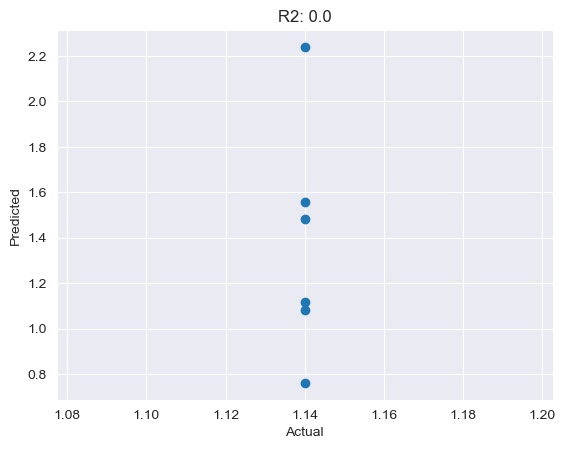

In [110]:
### Predicting the single monkey dose levels
## 2 iteration, 0.5 learning rate

single_dose_a = dose_model.predict(single_dose_X_validation)
print(len(dose_a), 
     )
single_dose_a_df = pd.DataFrame(single_dose_a)


# Plot the predictions vs. actual with the R2 score
fig, ax = plt.subplots()
ax.scatter(single_dose_y_validation, single_dose_a_df)


ax.plot([single_dose_y.min(), single_dose_y.max()], [single_dose_y.min(), single_dose_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

ax.set_xlabel('Actual Dose (Gy)')
ax.set_ylabel('Predicted Dose (Gy)')
#regression line
#single_y_validation, single_a_df = single_y_validation.reshape(-1,1), single_a_df.reshape(-1,1)
#ax.plot(single_y_validation, LinearRegression().fit(single_y_validation, single_a_df).predict(single_y_validation))



ax.set_title('R2: ' + str(r2_score(single_dose_y_validation, single_dose_a_df)))

plt.show()

#### Feature Analysis

##### Multi Monkey

In [111]:
# Find the feature importance for predicting the lmphocyte counts is a single monkey
dose_model.get_feature_importance(data=dose_pool,
                       #reference_data=None,
                       #type=EFstrType.ShapValues,
                       prettified=True,
                       #thread_count=-1,
                       #verbose=False,
                       #log_cout=sys.stdout,
                       #log_cerr=sys.stderr
)

#MONTHS AT IRRAD may be beecause the protocols had a standdard age to irradiate

,Feature Id,Importances
0,MONTHS AT IRRAD,78.373332
1,MONTHS_SINCE_IRRAD,4.828723
2,DAYS_SINCE_IRRAD,2.651864
3,SEX,2.217122
4,AGE,1.883568
5,Mean_corpuscular_hemaglobin_(MCH_pg),1.730285
6,Hemocrit_(HCT_%),1.326405
7,Mean_corpuscular_volume_(MCV_fL),0.835481
8,PLATLET_COUNT_(K/uL),0.768381
9,Mean_corpuscular_hemaglobin_concentration_(MCH...,0.746726


##### Single Monkey

In [112]:
dose_model.get_feature_importance(data=single_dose_pool,
                       #reference_data=None,
                       #type=EFstrType.ShapValues,
                       prettified=True,
                       #thread_count=-1,
                       #verbose=False,
                       #log_cout=sys.stdout,
                       #log_cerr=sys.stderr
)

,Feature Id,Importances
0,Hemocrit_(HCT_%),35.232249
1,Mean_corpuscular_hemaglobin_(MCH_pg),18.636849
2,Hemaglobin_(HGB_g/dL),14.508487
3,ABS_NEUT_(/uL),4.630418
4,AGE,3.569756
5,PLATLET_COUNT_(K/uL),3.119549
6,MONO_(%),3.037803
7,Mean_corpuscular_hemaglobin_concentration_(MCH...,2.834909
8,DAYS_SINCE_IRRAD,2.623971
9,Mean_corpuscular_volume_(MCV_fL),2.353940


#### Summary
We were able to accurately predict dose for the multi monkey data, but unsuccessful for the single monkey. This could be due to not giving the model properly formatted data, but is important for the first paper and as a diagnostic tool. The feature analysis seemed to produce feasible most important features for the accurate (multi monnkey) model.